# Analyze Cascade
Load cascade state obtained from Julia and use Qutip to track relevant metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qutip import Qobj
import qutip as qt

from pathlib import Path
import tomli

In [129]:
def plot_observable(x, y, ymin=None, ymax=None, label=None, ax=None, title=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(8, 4))
        fig.suptitle(title)

        ymin = 0 if not ymin else ymin
        ymax = max(y) + 0.2*max(y) if not ymax else ymax
        plot_stroke_overlays(ax, ymin, ymax)

    ax.plot(x, y, label=label)
    if label:
        plt.legend()
        
    return ax

def plot_stroke_overlays(ax, ymin, ymax):
    ax.fill_betweenx([ymin, ymax], 0, cycle_steps[0], alpha=0.1, fc='r')
    ax.fill_betweenx([ymin, ymax], secondstroke_t, thirdstroke_t, alpha=0.1, fc='b')

In [77]:
root = Path("./cascade_20D_I2")
with open(root / "config.toml", "rb") as f:
    config = tomli.load(f)

NDIMS = config["dims"]
dt = config["dt"]
alpha = config["cavity"]["alpha"]

isochore_steps = config["stroke_time"]["isochore"]
isochore_samplings = config["samplings"]["isochore"]
adiabatic_samplings = config["samplings"]["adiabatic"]

system_evolution = np.load(root / "cascade_evolution_1cycle.npz")
cavities_evolution = np.load(root / "cavities_evolution_1cycle.npz")

cycle_steps = np.load(root / "cycle_steps.npy")[1:]

samplings = sorted(system_evolution.files, key=lambda x: int(x))

firststroke_t = cycle_steps[0]
secondstroke_t = sum(cycle_steps[0:2]) + dt
thirdstroke_t = sum(cycle_steps[0:3]) + dt
fourthstroke_t = sum(cycle_steps[0:4]) + dt

samplings_times = [
    np.linspace(0, firststroke_t, isochore_samplings),
    np.linspace(firststroke_t + dt, secondstroke_t, adiabatic_samplings),
    np.linspace(secondstroke_t + dt, thirdstroke_t, isochore_samplings),
    np.linspace(thirdstroke_t + dt, fourthstroke_t, adiabatic_samplings)
]

# Flatten
sampling_times = np.array([x for l in samplings_times for x in l])

In [79]:
entropy = []
entropy1 = []
entropy2 = []
mutinf = []
concurrence = []

dims = np.sqrt(system_evolution["1"].shape[0])
s1_evolution = []
s2_evolution = []

for timestep in samplings:
    qobj = Qobj(system_evolution[timestep], dims=[[dims,dims], [dims,dims]])
    s1 = qobj.ptrace(1)
    s2 = qobj.ptrace(0)
    s1_evolution.append(s1)
    s2_evolution.append(s2)
    entropy.append(qt.entropy_vn(qobj))
    entropy1.append(qt.entropy_vn(s1))
    entropy2.append(qt.entropy_vn(s2))
    mutinf.append(qt.entropy_mutual(qobj, 0, 1))


## Cycles

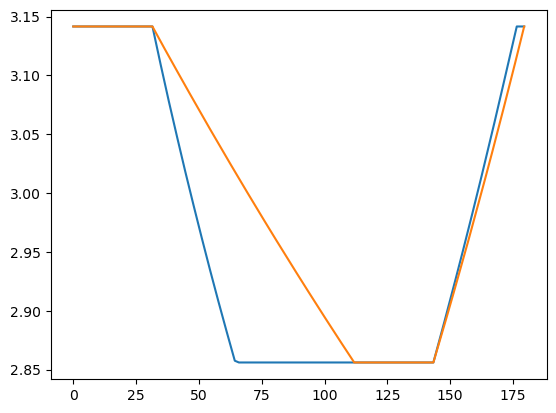

In [80]:
plt.plot(sampling_times, cavities_evolution["c1"])
plt.plot(sampling_times, cavities_evolution["c2"])

## Entropy

<Axes: >

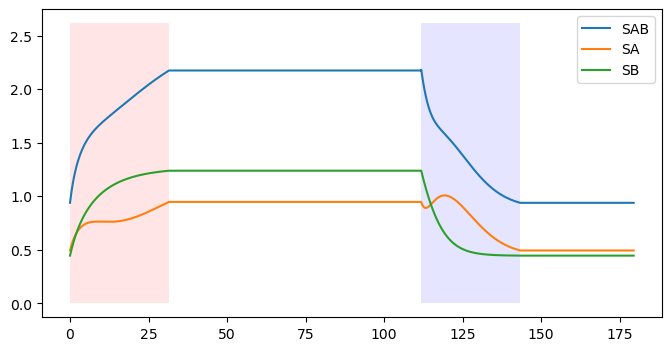

In [135]:
ax = plot_observable(sampling_times, entropy, ymax=ymax, label="SAB")
plot_observable(sampling_times, entropy1, label="SA", ax=ax)
plot_observable(sampling_times, entropy2, label="SB", ax=ax)

## Mutual Information

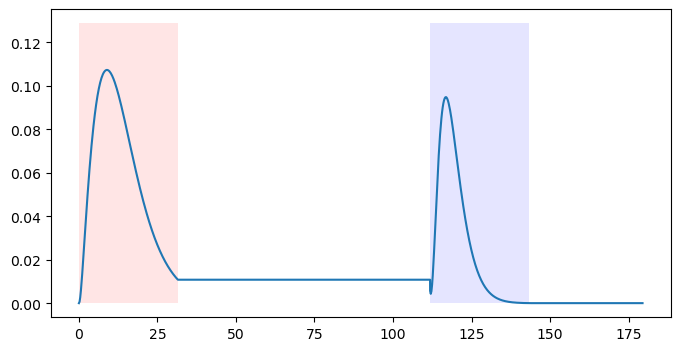

In [136]:
ax = plot_observable(sampling_times, mutinf)

## Heat

## Work

## Efficiency